In [113]:
import bosdyn.client
import bosdyn.client.util
import bosdyn.client.robot_command as bdcrc
from bosdyn.client.robot_command import RobotCommandBuilder
from bosdyn.client.robot_command import RobotCommandClient
from bosdyn.client.image import ImageClient
from bosdyn.client.manipulation_api_client import ManipulationApiClient

from bosdyn.util import seconds_to_duration
from bosdyn.geometry import EulerZXY

from bosdyn.client.world_object import WorldObjectClient
from bosdyn.client.frame_helpers import get_a_tform_b, get_vision_tform_body, BODY_FRAME_NAME, VISION_FRAME_NAME

from bosdyn.api import (arm_command_pb2, geometry_pb2, robot_command_pb2, synchronized_command_pb2,
                        trajectory_pb2, world_object_pb2, manipulation_api_pb2, image_pb2, estop_pb2, robot_state_pb2)

import cv2
from groundlight import Groundlight
import pdb
import time
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy

from PIL import Image
import io
np.random.seed(0)

%run sweeplight.ipynb  

In [3]:
#Setup
sdk = bosdyn.client.create_standard_sdk('ASTRO')
robot = sdk.create_robot('192.168.50.3')
id_client = robot.ensure_client('robot-id')

#Authenticate

robot.authenticate('user', 'r4kr99yw3hje')

#State
robot_state_client = robot.ensure_client('robot-state')

#Create command client
command_client = robot.ensure_client(RobotCommandClient.default_service_name)

#image client
image_client = robot.ensure_client(ImageClient.default_service_name)

#world image client
world_object_client = robot.ensure_client(WorldObjectClient.default_service_name)

#manipulation api client
manipulation_api_client = robot.ensure_client(ManipulationApiClient.default_service_name)

In [4]:
def getBattInfo():
    
    robot_state = robot_state_client.get_robot_state()
    
    battery_state = robot_state.battery_states[0]
    
    chargePercent = battery_state.charge_percentage
    
    runtimeRemaining = battery_state.estimated_runtime
    
    return chargePercent.value, runtimeRemaining.seconds

In [160]:
chargePercent, runtimeRemaining = getBattInfo()

print("Battery at:", chargePercent, "%. Robot has", runtimeRemaining, "seconds left")

Battery at: 0.0 %. Robot has 45 seconds left


In [6]:
lease_client = robot.ensure_client('lease')
lease = lease_client.acquire()
lease_keep_alive = bosdyn.client.lease.LeaseKeepAlive(lease_client)

In [125]:
#Power on and time_sync

robot.power_on(timeout_sec=20)

print(robot.is_powered_on())

robot.time_sync.wait_for_sync()

True


In [8]:
from bosdyn.client.graph_nav import GraphNavClient
from bosdyn.api.graph_nav import graph_nav_pb2
from bosdyn.api.graph_nav import map_pb2
from bosdyn.api.graph_nav import nav_pb2
from bosdyn.client.frame_helpers import get_odom_tform_body
from bosdyn.client.exceptions import ResponseError
from bosdyn.api import image_pb2

In [9]:
graph_nav_client = robot.ensure_client(GraphNavClient.default_service_name)
upload_filepath = "/home/gluser/groundlight/bdspot/spot/loopGraph"
timeoutSec = 10

In [10]:
def upload_graph_and_snapshots(upload_filepath, current_graph, 
                               graph_nav_client, current_waypoint_snapshots, current_edge_snapshots):
    """Upload the graph and snapshots to the robot."""
    print("Loading the graph from disk into local storage...")
    with open(upload_filepath + "/graph", "rb") as graph_file:
        # Load the graph from disk.
        data = graph_file.read()
        current_graph = map_pb2.Graph()
        current_graph.ParseFromString(data)
        print("Loaded graph has {} waypoints and {} edges".format(
            len(current_graph.waypoints), len(current_graph.edges)))
    for waypoint in current_graph.waypoints:
        # Load the waypoint snapshots from disk.
        with open(upload_filepath + "/waypoint_snapshots/{}".format(waypoint.snapshot_id),
                  "rb") as snapshot_file:
            waypoint_snapshot = map_pb2.WaypointSnapshot()
            waypoint_snapshot.ParseFromString(snapshot_file.read())
            current_waypoint_snapshots[waypoint_snapshot.id] = waypoint_snapshot
    for edge in current_graph.edges:
        if len(edge.snapshot_id) == 0:
            continue
        # Load the edge snapshots from disk.
        with open(upload_filepath + "/edge_snapshots/{}".format(edge.snapshot_id),
                  "rb") as snapshot_file:
            edge_snapshot = map_pb2.EdgeSnapshot()
            edge_snapshot.ParseFromString(snapshot_file.read())
            current_edge_snapshots[edge_snapshot.id] = edge_snapshot
    # Upload the graph to the robot.
    print("Uploading the graph and snapshots to the robot...")
    true_if_empty = not len(current_graph.anchoring.anchors)
    response = graph_nav_client.upload_graph(lease=lease.lease_proto,
                                                   graph=current_graph,
                                                   generate_new_anchoring=true_if_empty)
     
    # Upload the snapshots to the robot.
    
    for snapshot_id in response.unknown_waypoint_snapshot_ids:
        waypoint_snapshot = current_waypoint_snapshots[snapshot_id]
        graph_nav_client.upload_waypoint_snapshot(waypoint_snapshot)
        print("Uploaded {}".format(waypoint_snapshot.id))
    for snapshot_id in response.unknown_edge_snapshot_ids:
        edge_snapshot = current_edge_snapshots[snapshot_id]
        graph_nav_client.upload_edge_snapshot(edge_snapshot)
        print("Uploaded {}".format(edge_snapshot.id))

    # The upload is complete! Check that the robot is localized to the graph,
    # and if it is not, prompt the user to localize the robot before attempting
    # any navigation commands.
    localization_state = graph_nav_client.get_localization_state()
    if not localization_state.localization.waypoint_id:
        # The robot is not localized to the newly uploaded graph.
        print("\n")
        print("Upload complete! The robot is currently not localized to the map; please localize", \
               "the robot using commands (2) or (3) before attempting a navigation command.")
    return response

In [11]:
def set_initial_localization_fiducial(state_client, graph_nav_client):
    """Trigger localization when near a fiducial."""
    robot_state = state_client.get_robot_state()
    current_odom_tform_body = get_odom_tform_body(
        robot_state.kinematic_state.transforms_snapshot).to_proto()
    
    # Create an empty instance for initial localization since we are asking it to localize
    # based on the nearest fiducial.
    localization = nav_pb2.Localization()
    graph_nav_client.set_localization(initial_guess_localization=localization,
                                            ko_tform_body=current_odom_tform_body)

In [12]:
def check_success(graph_nav_client, command_id=-1):
    """Use a navigation command id to get feedback from the robot and sit when command succeeds."""
    if command_id == -1:
        # No command, so we have no status to check.
        return False
    status = graph_nav_client.navigation_feedback(command_id)
    if status.status == graph_nav_pb2.NavigationFeedbackResponse.STATUS_REACHED_GOAL:
        # Successfully completed the navigation commands!
        return True
    elif status.status == graph_nav_pb2.NavigationFeedbackResponse.STATUS_LOST:
        print("Robot got lost when navigating the route, the robot will now sit down.")
        return True
    elif status.status == graph_nav_pb2.NavigationFeedbackResponse.STATUS_STUCK:
        print("Robot got stuck when navigating the route, the robot will now sit down.")
        return True
    elif status.status == graph_nav_pb2.NavigationFeedbackResponse.STATUS_ROBOT_IMPAIRED:
        print("Robot is impaired.")
        return True
    else:
        # Navigation command is not complete yet.
        return False

In [13]:
def waitUntilFinishedNav(nav_to_cmd_id):
    is_finished = False
    prevTimeoutTimerSec = time.time()
    while(not is_finished):
        curTime = time.time()
        if(curTime - prevTimeoutTimerSec > timeoutSec):
            break
        time.sleep(0.2)
        is_finished = check_success(graph_nav_client, nav_to_cmd_id)

In [14]:
def spinInitFiducial(command_client, graph_nav_client, robot_state_client):
    timeoutSec = 5

    bdcrc.blocking_stand(command_client, timeout_sec = timeoutSec)
    
    for i in range(3):
        for j in range(4):
            print("attempt #: ", i*4+j)
            try:
                set_initial_localization_fiducial(robot_state_client, graph_nav_client)
                print("SUCCESS: initialized location to using nearest fiducial")
                return
            except ResponseError as e:
                print("Error during fiducial localization init: ", e)
            frameTreeSnapshot = robot.get_frame_tree_snapshot()
            cmd = RobotCommandBuilder.synchro_trajectory_command_in_body_frame(0, 0, np.pi/6, frame_tree_snapshot = frameTreeSnapshot)
            cmd_id = cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeoutSec)
            bdcrc.block_for_trajectory_cmd(command_client, cmd_id)
        frameTreeSnapshot = robot.get_frame_tree_snapshot()
        
        cmd = RobotCommandBuilder.synchro_trajectory_command_in_body_frame(0, 0.5, 0, frame_tree_snapshot = frameTreeSnapshot)
        cmd_id = cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeoutSec)
        bdcrc.block_for_trajectory_cmd(command_client, cmd_id)
    print("FAILED: could not find nearby fiducial")
       

In [15]:
# frameTreeSnapshot = robot.get_frame_tree_snapshot()
# cmd = RobotCommandBuilder.synchro_trajectory_command_in_body_frame(1, -0.5, 0, frame_tree_snapshot = frameTreeSnapshot)
# cmd_id = cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeoutSec)
# bdcrc.block_for_trajectory_cmd(command_client, cmd_id)

In [16]:
def moveToAndLookAt(moveTo, lookAt, blocking = True):
    """Takes in two 3 element arrays
        First is the coordinates for the gripper to move to
        Second is the coordinates for the gripper to look at
    """

    arm_pos_list = [moveTo[0],moveTo[1],moveTo[2]]
    dur_sec = 3

    duration = seconds_to_duration(dur_sec)


    arm_pos = geometry_pb2.Vec3(x=arm_pos_list[0], 
                                y=arm_pos_list[1], 
                                z=arm_pos_list[2])
    hand_pose = geometry_pb2.SE3Pose(position=arm_pos)
    hand_pose_traj_point = trajectory_pb2.SE3TrajectoryPoint(pose=hand_pose,
                                                             time_since_reference=duration)
    hand_traj = trajectory_pb2.SE3Trajectory(points=[hand_pose_traj_point])


    gaze_pos_list = [lookAt[0],lookAt[1],lookAt[2]]
    gaze_pos = geometry_pb2.Vec3(x=gaze_pos_list[0],
                                 y=gaze_pos_list[1],
                                 z=gaze_pos_list[2])
    gaze_pos_traj_point = trajectory_pb2.Vec3TrajectoryPoint(point=gaze_pos)
    gaze_traj = trajectory_pb2.Vec3Trajectory(points=[gaze_pos_traj_point])

    gaze_cmd = arm_command_pb2.GazeCommand.Request(target_trajectory_in_frame1=gaze_traj,
                                                   frame1_name='body',
                                                   tool_trajectory_in_frame2=hand_traj,
                                                   frame2_name='body')

    arm_command = arm_command_pb2.ArmCommand.Request(arm_gaze_command=gaze_cmd)
    synchronized_command = synchronized_command_pb2.SynchronizedCommand.Request(arm_command=arm_command)
    command = robot_command_pb2.RobotCommand(synchronized_command=synchronized_command)
    gaze_command_id = command_client.robot_command(command)
    if(blocking):
        bdcrc.block_until_arm_arrives(command_client, gaze_command_id, timeout_sec = time.time() + 3.0)

In [34]:
#Image capture from hand cam and save
def capImage(image_client, saveName):
    
    image_response = image_client.get_image_from_sources(["hand_color_image"])[0]
    image = Image.open(io.BytesIO(image_response.shot.image.data))
    image.save(saveName)

In [18]:
def graphInit(graph_nav_client, upload_filepath):
    
    current_graph = None
    current_waypoint_snapshots = dict()
    current_edge_snapshots = dict()
    
    response = upload_graph_and_snapshots(upload_filepath, current_graph, 
                               graph_nav_client, current_waypoint_snapshots, current_edge_snapshots)

    spinInitFiducial(command_client, graph_nav_client, robot_state_client)

    #Gets the current graph and reads off waypoints
    current_graph = graph_nav_client.download_graph()
    waypointList = [(waypoint.annotations.name,waypoint.id) for waypoint in current_graph.waypoints]
    waypointDict = dict()
    #make a dict and exclude default waypoints
    for waypointName, waypointId in waypointList:
        if(waypointName == 'default'):
            continue
        waypointDict[int(waypointName[9:])] = waypointId
    
    return waypointDict

In [19]:
def makeGLAPICall(det, graph_nav_client):
    
    #MUST CLEAR GRAPH PRIOR TO RUNNING, ARM CAMERA DOES NOT WORK IF GRAPH IS NOT CLEAR
    graph_nav_client.clear_graph()

    cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(1.0)
    cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeoutSec)
    print('Gripper opening')

    moveToAndLookAt([0.61,0,0.5],[1,0,-0.5], True)
    print('looking down')

    capImage(image_client, 'handColorImage.jpg')
    image_query = gl.submit_image_query(detector_id=det.id, image = "handColorImage.jpg")
    
    return image_query

In [20]:
def localizeObject():
    request_fiducials = [world_object_pb2.WORLD_OBJECT_APRILTAG]
    fiducial_objects = world_object_client.list_world_objects(
                object_type=request_fiducials).world_objects

    fid = None
    for fiducial_obj in fiducial_objects:
        if fiducial_obj.apriltag_properties.tag_id == 583:
            fid = fiducial_obj

    fid_tree_snapshot = fid.transforms_snapshot
    frame_tree_snapshot = robot.get_frame_tree_snapshot()
    
    #get_a_tform_b returns transformation such that a_coords = tform * b_coords

    fidToBody = bosdyn.client.frame_helpers.get_a_tform_b(fid_tree_snapshot, frame_a = 'body', frame_b ='filtered_fiducial_583')
    
    #obj fiducial
    # Position must be accurate to about 0.03m in x,y for a reliable grasp
    obj_pose_fid_frame_se2 = bosdyn.client.math_helpers.SE2Pose(-0.25,0,0)

    obj_pose_fid_frame_se3 = bosdyn.client.math_helpers.SE3Pose.from_se2(obj_pose_fid_frame_se2)
    #print(obj_pose_fid_frame_se3)

    obj_pose_body_frame_se3 = (fidToBody * obj_pose_fid_frame_se3)
    #print(obj_pose_body_frame_se3)

    obj_loc_body_frame_proto = obj_pose_body_frame_se3.to_proto().position
    #print(obj_loc_body_frame_proto)

    grasp = manipulation_api_pb2.PickObject(frame_name = 'body', object_rt_frame = obj_loc_body_frame_proto)

    grasp_request = manipulation_api_pb2.ManipulationApiRequest(pick_object = grasp)
    
    return grasp_request

In [21]:
def makeGrasp(grasp_request, graph_nav_client):
    
    graph_nav_client.clear_graph()
    
    cmd_response = manipulation_api_client.manipulation_api_command(
    manipulation_api_request = grasp_request)

    # Get feedback from the robot
    while True:
        feedback_request = manipulation_api_pb2.ManipulationApiFeedbackRequest(
            manipulation_cmd_id=cmd_response.manipulation_cmd_id)

        # Send the request
        response = manipulation_api_client.manipulation_api_feedback_command(
            manipulation_api_feedback_request=feedback_request)

        print('Current state: ',
              manipulation_api_pb2.ManipulationFeedbackState.Name(response.current_state))

        if response.current_state == manipulation_api_pb2.MANIP_STATE_GRASP_SUCCEEDED or response.current_state == manipulation_api_pb2.MANIP_STATE_GRASP_FAILED:
            break

        time.sleep(0.25)

    #creates carry override
    carry_override_rq = manipulation_api_pb2.ApiGraspedCarryStateOverride(override_request = 3)

    #creates override
    override_rq = manipulation_api_pb2.ApiGraspOverrideRequest(
        carry_state_override = carry_override_rq)

    #sends override so object can be stowed and carried
    response = manipulation_api_client.grasp_override_command(grasp_override_request = override_rq)
    
    cmd = RobotCommandBuilder.arm_stow_command()
    cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)

In [22]:
def checkForCubeAndGrasp(det, graph_nav_client):
    image_query = makeGLAPICall(det, graph_nav_client)

    grasp_request = None
    if image_query.result.label == 'PASS':
        grasp_request = localizeObject()
        print("RUBIK'S CUBE FOUND and localized")
        makeGrasp(grasp_request, graph_nav_client)
        print("GRASP MADE")
        return True
    else:
        print("NO RUBIK'S CUBE FOUND, continuing walk")
        cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(0.0)
        cmd = RobotCommandBuilder.arm_stow_command()
        cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)
        return False





In [126]:
bdcrc.blocking_selfright(command_client, timeout_sec = timeoutSec)

cmd = RobotCommandBuilder.arm_stow_command()
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)


cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(0.0)
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)

bdcrc.blocking_stand(command_client, timeout_sec = timeoutSec)

# InitializeGraph
waypointDict = graphInit(graph_nav_client, upload_filepath)

print('INITALIZED GRAPH')
print("________________")
print("")

Loading the graph from disk into local storage...
Loaded graph has 27 waypoints and 29 edges
Uploading the graph and snapshots to the robot...


Upload complete! The robot is currently not localized to the map; please localize the robot using commands (2) or (3) before attempting a navigation command.
attempt #:  0
Error during fiducial localization init:  bosdyn.api.graph_nav.SetLocalizationResponse (ResponseError): Code: 8 (STATUS_NO_MATCHING_FIDUCIAL)
attempt #:  1
Error during fiducial localization init:  bosdyn.api.graph_nav.SetLocalizationResponse (ResponseError): Code: 8 (STATUS_NO_MATCHING_FIDUCIAL)
attempt #:  2
SUCCESS: initialized location to using nearest fiducial
INITALIZED GRAPH
________________



In [104]:

# Initialize Groundlight API

GROUNDLIGHT_API_TOKEN = 'api_2Au8NPiTMbSLQ73Vjr2eMhX2qUh_pt4EEKhtDNgnjN3dUAr89YANDcYsmBkJZV'
gl = Groundlight(api_token=GROUNDLIGHT_API_TOKEN)

detectors = gl.list_detectors()

In [106]:
det = detectors.results[1]
print("INITALIZED GL API WITH DETECTOR:")
print(det)

INITALIZED GL API WITH DETECTOR:
id='det_2AuDZFz06xbytjWrTL0dUvsjOz7' type=<DetectorTypeEnum.detector: 'detector'> created_at=datetime.datetime(2022, 6, 21, 15, 30, 29, 961429, tzinfo=tzoffset(None, -25200)) name='newRubiksCube' query="Is entire Rubik's cube contained within image?" group_name='__DEFAULT' confidence_threshold=0.6


In [109]:
halfDet = detectors.results[0]
print("INITALIZED GL API WITH DETECTOR:")
print(halfDet)

INITALIZED GL API WITH DETECTOR:
id='det_2AwMOdKICxIoFUcOSNRu4yMQvTX' type=<DetectorTypeEnum.detector: 'detector'> created_at=datetime.datetime(2022, 6, 22, 9, 42, 43, 137493, tzinfo=tzoffset(None, -25200)) name='halfRubiksCube' query="Is over half of Rubik's cube contained within image" group_name='__DEFAULT' confidence_threshold=0.75


In [110]:
entireDet = detectors.results[1]
print("INITALIZED GL API WITH DETECTOR:")
print(entireDet)

INITALIZED GL API WITH DETECTOR:
id='det_2AuDZFz06xbytjWrTL0dUvsjOz7' type=<DetectorTypeEnum.detector: 'detector'> created_at=datetime.datetime(2022, 6, 21, 15, 30, 29, 961429, tzinfo=tzoffset(None, -25200)) name='newRubiksCube' query="Is entire Rubik's cube contained within image?" group_name='__DEFAULT' confidence_threshold=0.6


In [33]:
hasCube = False

for loopNum in range(3):
    for wpInd in [10, 9]:
        print('waypoint index:', wpInd, hasCube)
        nav_to_cmd_id = graph_nav_client.navigate_to(waypointDict[wpInd], timeoutSec)
        waitUntilFinishedNav(nav_to_cmd_id)
        if wpInd == 9:
            frameTreeSnapshot = robot.get_frame_tree_snapshot()
            cmd = RobotCommandBuilder.synchro_trajectory_command_in_body_frame(0, 0, np.pi/2, frame_tree_snapshot = frameTreeSnapshot)
            cmd_id = cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeoutSec)
            bdcrc.block_for_trajectory_cmd(command_client, cmd_id)
            res = checkForCubeAndGrasp(det, graph_nav_client)
            if(res):
                hasCube = True
            waypointDict = graphInit(graph_nav_client, upload_filepath)
        elif wpInd == 10:
            if hasCube:
                print('CUBE POSSESSED')
                cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(1.0)
                cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeoutSec)
                print('CUBE DROPPED')
                hasCube = False
                
        

waypoint index: 10 False
waypoint index: 9 False
Gripper opening
looking down
NO RUBIK'S CUBE FOUND, continuing walk
Loading the graph from disk into local storage...
Loaded graph has 27 waypoints and 29 edges
Uploading the graph and snapshots to the robot...


Upload complete! The robot is currently not localized to the map; please localize the robot using commands (2) or (3) before attempting a navigation command.
attempt #:  0
SUCCESS: initialized location to using nearest fiducial
waypoint index: 10 False
waypoint index: 9 False
Gripper opening
looking down
RUBIK'S CUBE FOUND and localized
GRASP MADE
Loading the graph from disk into local storage...
Loaded graph has 27 waypoints and 29 edges
Uploading the graph and snapshots to the robot...


Upload complete! The robot is currently not localized to the map; please localize the robot using commands (2) or (3) before attempting a navigation command.
attempt #:  0
SUCCESS: initialized location to using nearest fiducial
waypoint index:

In [137]:
moveToAndLookAt([0.60,0,0.5],[1,0,-0.5], True)
cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(1.0)
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeoutSec)

In [131]:
response = graph_nav_client.clear_graph()

In [155]:
frameTreeSnapshot = robot.get_frame_tree_snapshot()
cmd = RobotCommandBuilder.synchro_trajectory_command_in_body_frame(0, -0.5, np.pi/4, frame_tree_snapshot = frameTreeSnapshot)
cmd_id = cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeoutSec)
bdcrc.block_for_trajectory_cmd(command_client, cmd_id)



True

In [156]:
capImage(image_client, 'GLIMG/handColorImage.jpg')

GLIMG/handColorImage.jpg
(480, 640, 3)


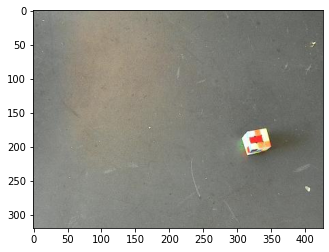

sliceImg-10.jpg
GLIMG/sliceImg-10.jpg
(320, 426, 3)


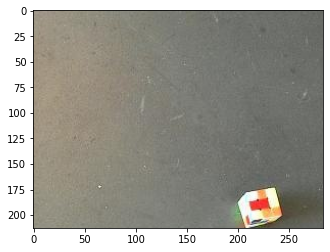

sliceImg-10.jpg
GLIMG/sliceImg-10.jpg
(213, 284, 3)


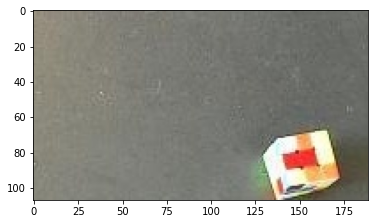

sliceImg-12.jpg
GLIMG/sliceImg-12.jpg
(107, 189, 3)


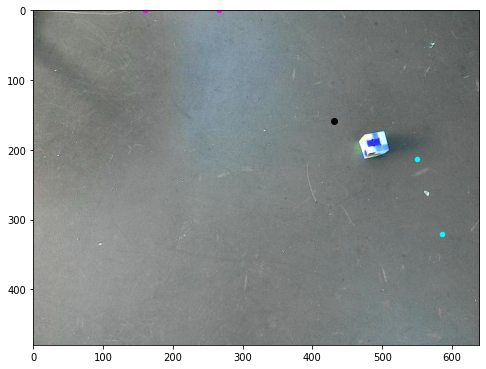

In [158]:
imgDir = 'GLIMG/'
imgName = 'handColorImage.jpg'
tree = sweepLocalize(entireDet, imgDir, imgName)
if tree is not None:
    img = cv2.imread(imgDir + imgName)
    plotTreeOnImage(tree, img)

GLIMG/handColorImage.jpg
(480, 640, 3)


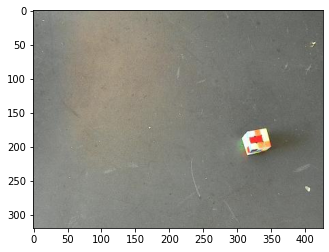

sliceImg-10.jpg
GLIMG/sliceImg-10.jpg
(320, 426, 3)


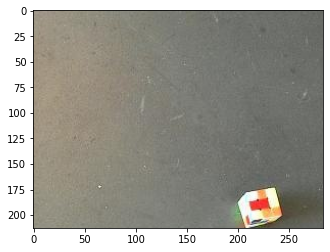

sliceImg-10.jpg
GLIMG/sliceImg-10.jpg
(213, 284, 3)


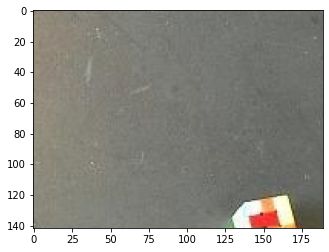

sliceImg-11.jpg
GLIMG/sliceImg-11.jpg
(142, 189, 3)


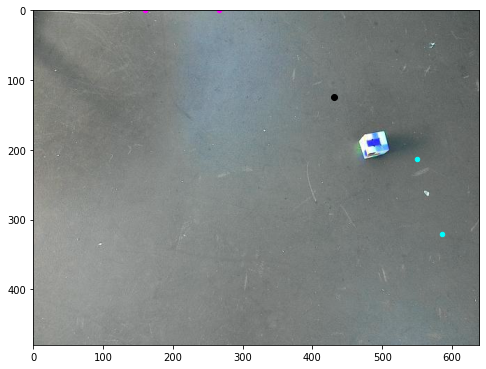

In [159]:
imgDir = 'GLIMG/'
imgName = 'handColorImage.jpg'
tree = sweepLocalize(halfDet, imgDir, imgName)
if tree is not None:
    img = cv2.imread(imgDir + imgName)
    plotTreeOnImage(tree, img)

In [60]:
#waypointDict = graphInit(graph_nav_client, upload_filepath)
nav_to_cmd_id = graph_nav_client.navigate_to(waypointDict[10], timeoutSec)
waitUntilFinishedNav(nav_to_cmd_id)

In [61]:
nav_to_cmd_id = graph_nav_client.navigate_to(waypointDict[9], timeoutSec)
waitUntilFinishedNav(nav_to_cmd_id)
frameTreeSnapshot = robot.get_frame_tree_snapshot()
cmd = RobotCommandBuilder.synchro_trajectory_command_in_body_frame(0, 0, np.pi/2, frame_tree_snapshot = frameTreeSnapshot)
cmd_id = cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeoutSec)
bdcrc.block_for_trajectory_cmd(command_client, cmd_id)

True

In [37]:
frameTreeSnapshot = robot.get_frame_tree_snapshot()
cmd = RobotCommandBuilder.synchro_trajectory_command_in_body_frame(0, 0, np.pi/3, frame_tree_snapshot = frameTreeSnapshot)
cmd_id = cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeoutSec)
bdcrc.block_for_trajectory_cmd(command_client, cmd_id)

True

In [121]:
res = checkForCubeAndGrasp(det, graph_nav_client)

Gripper opening
looking down
RUBIK'S CUBE FOUND and localized
Current state:  MANIP_STATE_SEARCHING_FOR_GRASP
Current state:  MANIP_STATE_SEARCHING_FOR_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Curren

In [42]:
cmd = RobotCommandBuilder.arm_stow_command()
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)
bdcrc.block_until_arm_arrives(command_client, cmd_id, timeout_sec = time.time() + 3.0)

bdcrc.blocking_sit(command_client, timeout_sec = timeoutSec)

cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(1.0)
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeoutSec)

In [297]:
cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(1.0)
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeoutSec)

In [309]:
nav_to_cmd_id = graph_nav_client.navigate_to(waypointDict[10], timeoutSec)

RobotNotLocalizedToRouteError: bosdyn.api.graph_nav.NavigateToResponse (RobotNotLocalizedToRouteError): The current localization doesn't refer to any waypoint in the route (possibly uninitialized localization).

In [240]:
nav_to_cmd_id = graph_nav_client.navigate_to(waypointDict[9], timeoutSec)
waitUntilFinishedNav(nav_to_cmd_id)



True

In [249]:
# image_query = makeGLAPICall(det, graph_nav_client)

# grasp_request = None
# if image_query.result.label == 'PASS':
#     grasp_request = localizeObject()
#     print("RUBIK'S CUBE FOUND and localized")
# else:
#     print("NO RUBIK'S CUBE FOUND, continuing walk")
#     cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(0.0)
    
    
# if grasp_request is not None:
#     makeGrasp(grasp_request)
#     print("GRASP MADE")
    
    
# cmd = RobotCommandBuilder.arm_stow_command()
# cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)

# waypointDict = graphInit(graph_nav_client, upload_filepath)
# nav_to_cmd_id = graph_nav_client.navigate_to(waypointDict[10], timeoutSec)

Arm Ready
Gripper opening
looking down
NO RUBIK'S CUBE FOUND, continuing walk


AttributeError: type object 'RobotCommandBuilder' has no attribute 'gripper_close_command'